# Data Science Capstone 2

## Weather Forecaster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [4]:
#Load the datasets
weather_dataset = pd.read_csv("modified_data/weather_prediction_dataset_finalized.csv")

#This dataset is optional and provides a template showing all the times the weather is appropriate for a picnic
weather_for_picnic = pd.read_csv("raw_data/weather_prediction_bbq_labels.csv")

In [5]:
weather_dataset.head(30)

,CITY,MONTH,cloud_cover,humidity,pressure,global_radiation,precipitation,sunshine,temp_mean,temp_min,temp_max,target,wind_speed,wind_gust
0,BASEL,1,8.0,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3.6,NaN,NaN
1,DUSSELDORF,1,8.0,0.92,1.0240,0.12,0.22,0.0,4.2,2.5,6.9,6.5,2.5,5.9
2,HEATHROW,1,7.0,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,7.9,NaN,NaN
3,KASSEL,1,NaN,0.93,1.0237,0.06,0.13,0.0,3.5,1.5,5.0,2.3,2.5,8.2
4,LJUBLJANA,1,6.0,0.83,1.0294,0.57,0.00,5.2,-4.8,-9.1,-1.3,-0.9,0.4,NaN
5,DE_BILT,1,7.0,0.97,1.0240,0.11,0.10,0.0,6.1,3.5,8.1,7.3,2.5,8.0
6,MAASTRICHT,1,8.0,0.98,1.0251,0.06,0.17,0.0,5.6,4.1,6.9,6.2,3.1,7.0
7,MALMO,1,NaN,NaN,NaN,NaN,0.27,NaN,2.9,0.9,3.6,3.7,2.5,NaN
8,TOURS,1,NaN,0.97,1.0275,0.25,0.04,NaN,8.5,7.2,9.8,7.9,1.6,NaN
9,MUENCHEN,1,8.0,0.91,1.0273,0.20,0.20,0.0,1.7,-0.5,2.6,1.9,2.6,9.4


In [6]:
tscv = TimeSeriesSplit(n_splits=5)
for train_ind, test_ind in tscv.split(weather_dataset):
    train, test = weather_dataset.iloc[train_ind], weather_dataset.iloc[test_ind]

In [7]:
X_train = train.drop(columns='target')
y_train = train.target
X_test = test.drop(columns='target')
y_test = test.target

In [9]:
names_list = ['CITY', 'MONTH']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((54795, 11), (10959, 11))

### Decision Tree (Old Model)

In [16]:
DT_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=3),
    DecisionTreeRegressor(random_state=5)
)

In [43]:
cv_scores_dt = cross_validate(DT_pipe, X_train, y_train, cv=5)

In [18]:
#[0.87266547 0.86615549 0.88510769 0.89841968 0.8506437 ]
print(cv_scores_dt['test_score'])

[0.86072754 0.85532187 0.87296435 0.89193254 0.84059208]


In [19]:
DT_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=3,
                             score_func=<function f_regression at 0x000002A4442C1D00>)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=5))])

In [20]:
y_train_DT_pred = DT_pipe.predict(X_train)
y_test_DT_pred = DT_pipe.predict(X_test)

In [48]:
r2 = r2_score(y_train, y_train_DT_pred), r2_score(y_test, y_test_DT_pred)
RMSE = mean_squared_error(y_train, y_train_DT_pred, squared=False), mean_squared_error(y_test, y_test_DT_pred, squared=False)
print("R-squared for decision tree model with mean imputation:", r2)
print("RMSE for decision tree model with mean imputation:", RMSE)

R-squared for decision tree model with mean imputation: (0.9949466419699246, 0.8761748851082471)
RMSE for decision tree model with mean imputation: (np.float64(0.5962733268744127), np.float64(2.9710002896075953))


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
dt_neg_mae = cross_validate(DT_pipe, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
dt_mae_mean = np.mean(-1 * dt_neg_mae['test_score'])
dt_mae_std = np.std(-1 * dt_neg_mae['test_score'])
mean_absolute_error(y_test, DT_pipe.predict(X_test))

np.float64(2.311251634881528)

In [26]:
dt_scores = cv_scores_dt['test_score']
dt_scores

array([0.86072754, 0.85532187, 0.87296435, 0.89193254, 0.84059208])

In [49]:
dt_r2 = r2
dt_r2

(0.9949466419699246, 0.8761748851082471)

In [37]:
dt_times_fit = cv_scores_dt['fit_time']
dt_times_score = cv_scores_dt['score_time']
dt_times_fit

array([0.47592664, 0.46474051, 0.44078684, 0.4373579 , 0.44106579])

The values seen above for the decision tree represent a portion of the old weather forecaster model that was tasked with predicting temperature. The most notable issues seen was overfitting to the training data that led to reduced accuracy during the cross validation and testing phase.

### Linear Regression

In [38]:
LR_pipe = make_pipeline(
    SimpleImputer(strategy='mean'), 
    StandardScaler(),
    LinearRegression()
)

In [44]:
cv_scores_lr = cross_validate(LR_pipe, X_train, y_train, cv=5)

In [40]:
LR_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [41]:
y_train_LR_pred = LR_pipe.predict(X_train)
y_test_LR_pred = LR_pipe.predict(X_test)

In [50]:
r2 = r2_score(y_train, y_train_LR_pred), r2_score(y_test, y_test_LR_pred)
RMSE = mean_squared_error(y_train, y_train_LR_pred, squared=False), mean_squared_error(y_test, y_test_LR_pred, squared=False)
print("R-squared for linear regression model with mean imputation:", r2)
print("RMSE for linear regression model with mean imputation:", RMSE)

R-squared for linear regression model with mean imputation: (0.9372200034181397, 0.9409824126740324)
RMSE for linear regression model with mean imputation: (np.float64(2.101677098219429), np.float64(2.051110462823506))


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
lr_scores = cv_scores_lr['test_score']
lr_scores

array([0.93371659, 0.92986521, 0.9396032 , 0.95011911, 0.92192104])

In [46]:
lr_times_fit = cv_scores_lr['fit_time']
lr_times_score = cv_scores_lr['score_time']
lr_times_fit

array([0.15921664, 0.11490345, 0.10552382, 0.10167551, 0.1005218 ])

In [51]:
lr_r2 = r2
lr_r2

(0.9372200034181397, 0.9409824126740324)

### Random Forest

In [52]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=5)
)

In [53]:
cv_scores_rf = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [54]:
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=5))])

In [55]:
y_train_RF_pred = RF_pipe.predict(X_train)
y_test_RF_pred = RF_pipe.predict(X_test)

In [56]:
r2 = r2_score(y_train, y_train_RF_pred), r2_score(y_test, y_test_RF_pred)
RMSE = mean_squared_error(y_train, y_train_RF_pred, squared=False), mean_squared_error(y_test, y_test_RF_pred, squared=False)
print("R-squared for random forest model with mean imputation:", r2)
print("RMSE for random forest model with mean imputation:", RMSE)

R-squared for random forest model with mean imputation: (0.9918980196643992, 0.9452430548554733)
RMSE for random forest model with mean imputation: (np.float64(0.7550069341702312), np.float64(1.9756860341416411))


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
rf_scores = cv_scores_rf['test_score']
print(rf_scores)
rf_times_fit = cv_scores_rf['fit_time']
rf_times_score = cv_scores_rf['score_time']
print(rf_times_fit)
rf_r2 = r2
rf_r2

[0.93721296 0.93302379 0.94225063 0.9523483  0.92566994]
[83.8090744  86.57792044 87.36419654 89.05165839 88.86786819]


(0.9918980196643992, 0.9452430548554733)

### CatBoost

In [58]:
import os
import pickle
import catboost
import lightgbm

In [60]:
model_path = 'models/weather_forecaster_temperature_model_catboost.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        cat_model = pickle.load(f)
else:
    print("Expected model not found")

In [61]:
cv_scores_cat = cross_validate(cat_model, X_train, y_train, cv=5)

In [62]:
cat_model.fit(X_train, y_train)

In [63]:
y_train_cat_pred = cat_model.predict(X_train)
y_test_cat_pred = cat_model.predict(X_test)

In [64]:
r2 = r2_score(y_train, y_train_cat_pred), r2_score(y_test, y_test_cat_pred)
RMSE = mean_squared_error(y_train, y_train_cat_pred, squared=False), mean_squared_error(y_test, y_test_cat_pred, squared=False)
print("R-squared for catboost:", r2)
print("RMSE for catboost:", RMSE)

R-squared for catboost: (0.9545597975544147, 0.949058117603792)
RMSE for catboost: (np.float64(1.7880327811062335), np.float64(1.9056178788253324))


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
cat_scores = cv_scores_cat['test_score']
print(cat_scores)
cat_times_fit = cv_scores_cat['fit_time']
cat_times_score = cv_scores_cat['score_time']
print(cat_times_fit)
cat_r2 = r2
cat_r2

[0.94096289 0.93735785 0.94710464 0.95459213 0.9298998 ]
[27.19613457 23.47317791 23.81331635 24.37604237 23.47204399]


(0.9545597975544147, 0.949058117603792)

### LightGBM

In [66]:
model_path = 'models/weather_forecaster_temperature_model_lightgbm.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        light_model = pickle.load(f)
else:
    print("Expected model not found")

In [67]:
cv_scores_light = cross_validate(light_model, X_train, y_train, cv=5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 43836, number of used features: 11
[LightGBM] [Info] Start training from score 10.033940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 43836, number of used features: 11
[LightGBM] [Info] Start training from score 10.569797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2173
[LightGBM] [Info] Number of data points in the train set: 43836, number of used features: 11
[LightGBM] [Info] Start t

In [68]:
light_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 54795, number of used features: 11
[LightGBM] [Info] Start training from score 10.207930


LGBMRegressor(learning_rate=0.05, n_estimators=500, num_leaves=50)

In [69]:
y_train_light_pred = light_model.predict(X_train)
y_test_light_pred = light_model.predict(X_test)

In [70]:
r2 = r2_score(y_train, y_train_light_pred), r2_score(y_test, y_test_light_pred)
RMSE = mean_squared_error(y_train, y_train_cat_pred, squared=False), mean_squared_error(y_test, y_test_cat_pred, squared=False)
print("R-squared for LightGBM:", r2)
print("RMSE for LightGBM:", RMSE)

R-squared for LightGBM: (0.9586324412971149, 0.947947851706846)
RMSE for LightGBM: (np.float64(1.7880327811062335), np.float64(1.9056178788253324))


C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tanks\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
light_scores = cv_scores_light['test_score']
print(light_scores)
light_times_fit = cv_scores_light['fit_time']
light_times_score = cv_scores_light['score_time']
print(light_times_fit)
light_r2 = r2
light_r2

[0.94116684 0.93629048 0.94665048 0.95415027 0.92961633]
[3.29920793 3.41025996 3.41662765 3.93078661 3.74113345]


(0.9586324412971149, 0.947947851706846)

### Data Visualizations

In [ ]:
# Plot 1: Cross validation accuracies

In [74]:
iterations = np.linspace(1, 5, num=5, dtype=int)
iterations

array([1, 2, 3, 4, 5])

In [100]:
df_1 = pd.DataFrame({"iterations": iterations,
                    "Original": dt_scores,
                  "Linear Reg.": lr_scores,
                  "Random Forest": rf_scores,
                  "CatBoost": cat_scores,
                  "LightGBM": light_scores})
df_1

,iterations,Original,Linear Reg.,Random Forest,CatBoost,LightGBM
0,1,0.860728,0.933717,0.937213,0.940963,0.941167
1,2,0.855322,0.929865,0.933024,0.937358,0.936290
2,3,0.872964,0.939603,0.942251,0.947105,0.946650
3,4,0.891933,0.950119,0.952348,0.954592,0.954150
4,5,0.840592,0.921921,0.925670,0.929900,0.929616


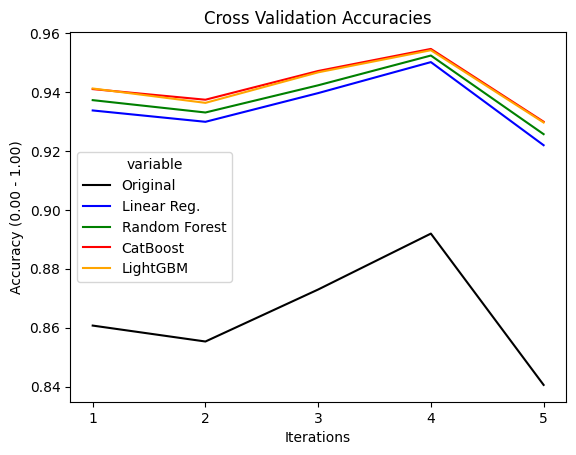

In [121]:
sns.lineplot(x='iterations', y='value', hue='variable',
             data=pd.melt(df_1, ["iterations"]),
            palette=['black', 'blue', 'green', 'red', 'orange'])

plt.xticks(ticks=np.arange(1, 6, 1))
plt.title("Cross Validation Accuracies")
plt.xlabel("Iterations")
plt.ylabel("Accuracy (0.00 - 1.00)")
plt.show()

In [76]:
dt_scores

array([0.86072754, 0.85532187, 0.87296435, 0.89193254, 0.84059208])

In [ ]:
# Plot 2: Training vs Testing r-squared values

In [105]:
model_names = ["Original", "Original", "Linear Reg.", "Linear Reg.", "Random Forest", "Random Forest",
               "CatBoost", "CatBoost", "LightGBM", "LightGBM"]

In [106]:
dataset_type = ["Train", "Test", "Train", "Test", "Train", "Test", "Train", "Test", "Train", "Test"]

In [107]:
df_2 = pd.DataFrame({"Models": model_names,
                     "Dataset": dataset_type,
                     "R2 Values": [dt_r2[0], dt_r2[1], lr_r2[0], lr_r2[1], rf_r2[0], rf_r2[1],
                                   cat_r2[0], cat_r2[1], light_r2[0], light_r2[1]]})
df_2

,Models,Dataset,R2 Values
0,Original,Train,0.994947
1,Original,Test,0.876175
2,Linear Reg.,Train,0.937220
3,Linear Reg.,Test,0.940982
4,Random Forest,Train,0.991898
5,Random Forest,Test,0.945243
6,CatBoost,Train,0.954560
7,CatBoost,Test,0.949058
8,LightGBM,Train,0.958632
9,LightGBM,Test,0.947948


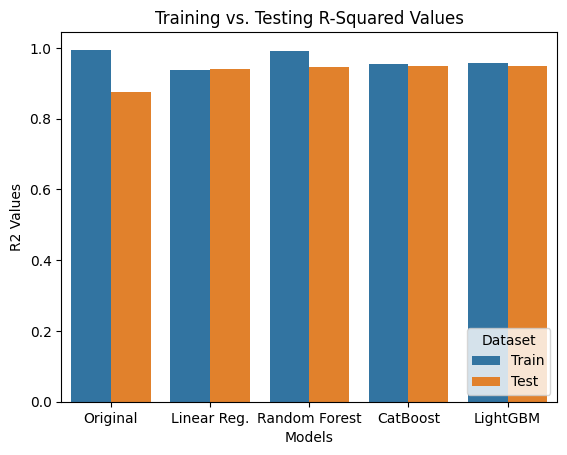

In [128]:
f = sns.barplot(x="Models",
            y="R2 Values",
            hue="Dataset",
            data=df_2)

plt.title("Training vs. Testing R-Squared Values")
sns.move_legend(f, "lower right")
plt.show()

In [ ]:
# Plot 3: Model fitting/training times

In [117]:
df_3 = pd.DataFrame({"iterations": iterations,
                    "Original": dt_times_fit,
                  "Linear Reg.": lr_times_fit,
                  "Random Forest": rf_times_fit,
                  "CatBoost": cat_times_fit,
                  "LightGBM": light_times_fit})
df_3

,iterations,Original,Linear Reg.,Random Forest,CatBoost,LightGBM
0,1,0.475927,0.159217,83.809074,27.196135,3.299208
1,2,0.464741,0.114903,86.577920,23.473178,3.410260
2,3,0.440787,0.105524,87.364197,23.813316,3.416628
3,4,0.437358,0.101676,89.051658,24.376042,3.930787
4,5,0.441066,0.100522,88.867868,23.472044,3.741133


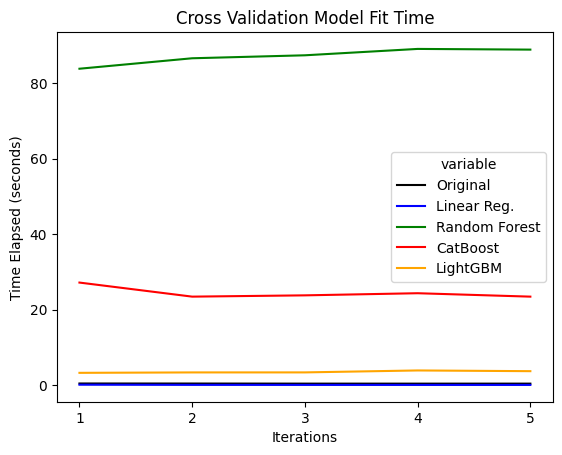

In [122]:
g1 = sns.lineplot(x='iterations', y='value', hue='variable',
             data=pd.melt(df_3, ["iterations"]),
            palette=['black', 'blue', 'green', 'red', 'orange'])

plt.xticks(ticks=np.arange(1, 6, 1))
plt.title("Cross Validation Model Fit Time")
plt.xlabel("Iterations")
plt.ylabel("Time Elapsed (seconds)")
plt.show()

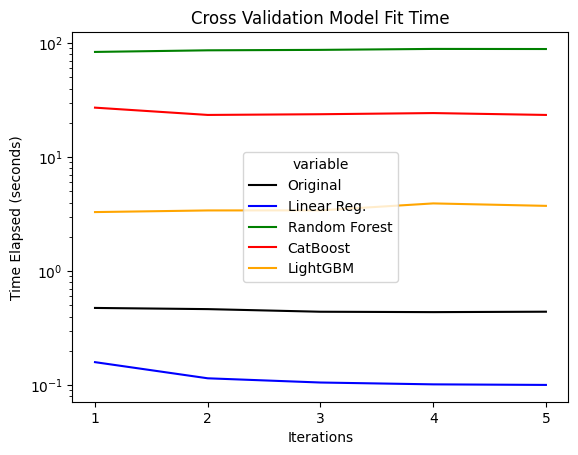

In [123]:
g2 = sns.lineplot(x='iterations', y='value', hue='variable',
             data=pd.melt(df_3, ["iterations"]),
            palette=['black', 'blue', 'green', 'red', 'orange'])

plt.xticks(ticks=np.arange(1, 6, 1))
g2.set(yscale='log')
plt.title("Cross Validation Model Fit Time")
plt.xlabel("Iterations")
plt.ylabel("Time Elapsed (seconds)")
plt.show()

In [ ]:
# Plot 4: Model test scoring times

In [129]:
df_4 = pd.DataFrame({"iterations": iterations,
                    "Original": dt_times_score,
                  "Linear Reg.": lr_times_score,
                  "Random Forest": rf_times_score,
                  "CatBoost": cat_times_score,
                  "LightGBM": light_times_score})
df_4

,iterations,Original,Linear Reg.,Random Forest,CatBoost,LightGBM
0,1,0.017088,0.010617,0.707015,0.041901,0.105361
1,2,0.017028,0.012260,0.738500,0.052404,0.122420
2,3,0.017922,0.011919,0.760845,0.065026,0.110975
3,4,0.017320,0.012046,0.802386,0.042511,0.119025
4,5,0.018146,0.008957,0.812592,0.026997,0.119785


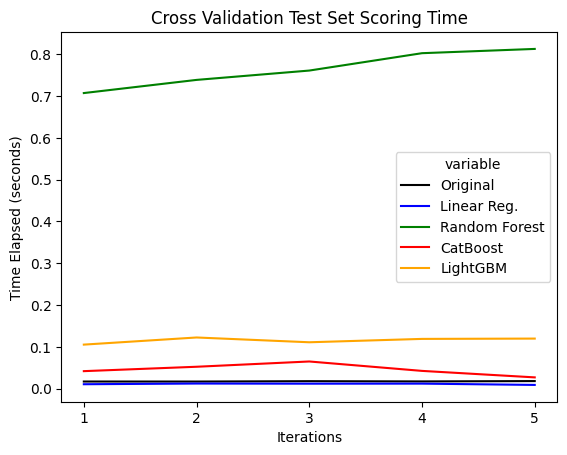

In [131]:
g3 = sns.lineplot(x='iterations', y='value', hue='variable',
             data=pd.melt(df_4, ["iterations"]),
            palette=['black', 'blue', 'green', 'red', 'orange'])

plt.xticks(ticks=np.arange(1, 6, 1))
plt.title("Cross Validation Test Set Scoring Time")
plt.xlabel("Iterations")
plt.ylabel("Time Elapsed (seconds)")
plt.show()

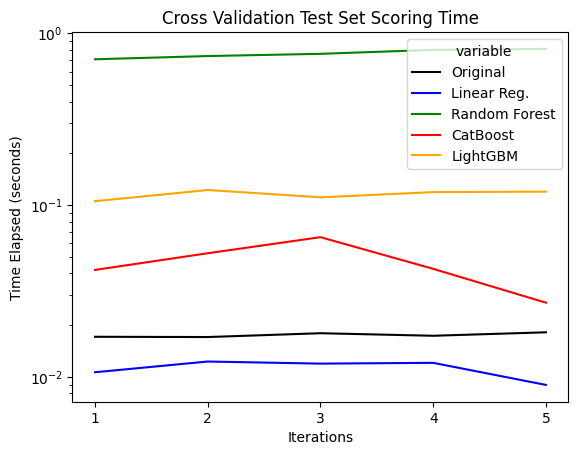

In [133]:
g4 = sns.lineplot(x='iterations', y='value', hue='variable',
             data=pd.melt(df_4, ["iterations"]),
            palette=['black', 'blue', 'green', 'red', 'orange'])

plt.xticks(ticks=np.arange(1, 6, 1))
g4.set(yscale='log')
plt.title("Cross Validation Test Set Scoring Time")
sns.move_legend(g4, "upper right")
plt.xlabel("Iterations")
plt.ylabel("Time Elapsed (seconds)")
plt.show()